# Import dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import time

## First example 

In [32]:
# create general model
model = pyo.ConcreteModel()

model.x = pyo.Var(within = Integers, bounds=(0, 10))
model.y = pyo.Var(bounds=(0, 10))

x = model.x
y = model.y

# specify model
model.c1 = pyo.Constraint(expr=-x+2*y <= 7)
model.c2 = pyo.Constraint(expr=2*x+y <= 14)
model.c3 = pyo.Constraint(expr=2*x-y <= 10)

model.obj = pyo.Objective(expr=x+y, sense=maximize)

# solve model
opt = SolverFactory('glpk')
opt.solve(model)

# model results
x_value = pyo.value(x)
y_value = pyo.value(y)

model.pprint()
print('--'*33)
print(f'x: {x_value}')
print(f'y: {y_value}')

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   4.0 :    10 : False : False : Integers
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   5.5 :    10 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x + y

3 Constraint Declarations
    c1 : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :  -Inf : - x + 2*y :   7.0 :   True
    c2 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x + y :  14.0 :   True
    c3 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x - y :  10.0 :   True

6 Declarations: x y c1 c2 c3 obj
----------------------------------------------

## Second Example

In [28]:
model = pyo.ConcreteModel()
model.x = pyo.Var(bounds=(-np.inf, 3))
model.y = pyo.Var(bounds=(0, np.inf))

x = model.x
y = model.y

model.c1 = pyo.Constraint(expr=x + y <= 8)
model.c2 = pyo.Constraint(expr=8 * x + 3 * y >= -24)
model.c3 = pyo.Constraint(expr=-6 * x + 8 * y <= 48)
model.c4 = pyo.Constraint(expr=3 * x + 5 * y <= 15)

model.obj = pyo.Objective(expr=-4 * x - 2 * y, sense=minimize)

t0 = time.time()
opt = SolverFactory('glpk')
opt.solve(model)
t1 = time.time()

x_value = pyo.value(x)
y_value = pyo.value(y)

print(f'x: {x_value}')
print(f'y: {y_value}')

print('--'*33)
print(f'Optimization process completed in: {t1-t0} seconds.')

x: 3.0
y: 1.2
------------------------------------------------------------------
Optimization process completed in: 0.06119823455810547 seconds.


## Electricity Problem

In [11]:
#import data
gen = pd.read_excel(io='data/inputs_electricity.xlsx', sheet_name='gen')
load = pd.read_excel(io='data/inputs_electricity.xlsx', sheet_name='load')
Ng = len(gen)

print(gen.head())
print()
print(load.head())

   id  limit  cost
0   0     20  0.10
1   1     10  0.05
2   2     40  0.30
3   3     50  0.40
4   4      5  0.01

   id  value
0   0     50
1   1     20
2   2     30


In [23]:
# specify model
model = pyo.ConcreteModel()

# variables
model.Pg = pyo.Var(range(Ng), bounds=(0, None))
Pg = model.Pg

# constraints
pg_sum = sum([Pg[g] for g in gen.id])
model.balance = pyo.Constraint(expr= pg_sum == sum(load.value))

model.c1 = pyo.Constraint(expr=Pg[0]+Pg[3] >= load.value[0])
model.limits = pyo.ConstraintList()
for g in gen.id:
    model.limits.add(expr= Pg[g] <= gen.limit[g])

# objective
cost_sum = sum([Pg[g]*gen.cost[g] for g in gen.id])
model.obj = pyo.Objective(expr = cost_sum, sense=minimize)

# solve model
opt = SolverFactory('glpk')
opt.solve(model)

# add the results to the dataframe so it can be easily visualized 
gen['Pg'] = [round(pyo.value(Pg[g])) for g in gen.id]
print(gen)

   id  limit  cost  Pg
0   0     20  0.10  20
1   1     10  0.05  10
2   2     40  0.30  35
3   3     50  0.40  30
4   4      5  0.01   5


## Exercise on Mixed-Integer Linear Programming

In [45]:
# specify model and variables
model = pyo.ConcreteModel()
range_i = range(1,6)
model.x = pyo.Var(range_i, within = Integers, bounds = (0, None))
model.y = pyo.Var(within = Reals, bounds = (0, None))

x = model.x
y = model.y

# constraints
model.c1 = pyo.Constraint(expr= sum([x[i] for i in range_i]) + y <= 20 )
model.c2 = pyo.ConstraintList()
for i in range_i:
    model.c2.add(expr = x[i] + y >= 15)
model.c3 = pyo.Constraint(expr = sum([i*x[i] for i in range_i]) >= 10 )
model.c4 = pyo.Constraint(expr = x[5] + 2*y >= 30)

# objective function
model.obj = pyo.Objective(expr = sum([x[i] for i in range_i]) + y, sense = minimize)

# solve model
opt = SolverFactory('glpk')
opt.solve(model)

# display results
vars_names = ['x_'+str(i) for i in range_i]
vars_names.append('y')
vars_names.append('obj_result')

vars_results = [pyo.value(x[i]) for i in range_i]
vars_results.append(pyo.value(y))
vars_results.append(sum([j for j in vars_results]))


df = pd.DataFrame({'variables': vars_names, 
                   'values': vars_results})

print(df)

    variables  values
0         x_1     0.0
1         x_2     0.0
2         x_3     0.0
3         x_4     0.0
4         x_5     2.0
5           y    15.0
6  obj_result    17.0


## Non Linear Programming

In [6]:
# create general model
model = pyo.ConcreteModel()

model.x = pyo.Var(within = Integers, bounds=(0, 10))
model.y = pyo.Var(bounds=(0, 10))

x = model.x
y = model.y

# specify model
model.c1 = pyo.Constraint(expr=-x+2*y*x <= 8)
model.c2 = pyo.Constraint(expr=2*x+y <= 14)
model.c3 = pyo.Constraint(expr=2*x-y <= 10)

model.obj = pyo.Objective(expr=x+y*x, sense=maximize)

# solve model
opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

# model results
x_value = pyo.value(x)
y_value = pyo.value(y)

model.pprint()
print('--'*33)
print(f'x: {x_value}')
print(f'y: {y_value}')

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 5.6067151589768685 :    10 : False : False : Integers
    y : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 1.2134302215032389 :    10 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x + y*x

3 Constraint Declarations
    c1 : Size=1, Index=None, Active=True
        Key  : Lower : Body        : Upper : Active
        None :  -Inf : - x + 2*y*x :   8.0 :   True
    c2 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x + y :  14.0 :   True
    c3 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :  -Inf : 2*x - y :  10.0 :   True

6 Declarations: x y c

## Ex. Non Linear Problem

In [19]:
model = pyo.ConcreteModel()

N = 0
model.x = pyo.Var(initialize=N, bounds=(-5,5))
model.y = pyo.Var(initialize=N, bounds=(-5,5))

x = model.x
y = model.y

model.obj = pyo.Objective(expr=cos(x)*cos(y)+cos(x+1), sense=maximize)

opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

# model results
x_value = pyo.value(x)
y_value = pyo.value(y)

model.pprint()
print('--'*33)
print(f'x: {x_value}')
print(f'y: {y_value}')

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :    -5 : -0.4999999999423102 :     5 : False : False :  Reals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :    -5 :   0.0 :     5 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : cos(x)*cos(y) + cos(x + 1)

3 Declarations: x y obj
------------------------------------------------------------------
x: -0.4999999999423102
y: 0.0


## Genetic Algorithm - Basic Example

In [28]:
from geneticalgorithm import geneticalgorithm as ga
import numpy as np
import pandas as pd

 The best solution found:                                                                           
 [5.         1.29920592]

 Objective function:
 -11.49602960137894


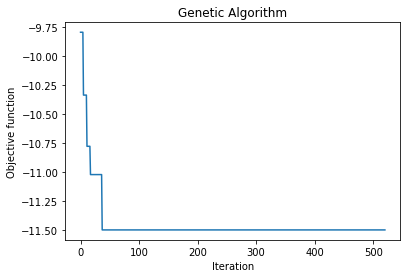

In [27]:
def f(x):
    pen = 0
    if not -x[0]+2*x[1]*x[0] <= 8 :
        pen = np.inf
    if not 2*x[0] +x[1] <= 14 :
        pen = np.inf
    if not 2*x[0] - x[1] <= 10:
        pen = np.inf
    obj_fun = -(x[0] + x[1]*x[0]) + pen
    return obj_fun

varbounds = np.array([[0,10],[0,10]])
vartype = np.array([['int'],['real']])

model = ga(function=f, dimension=2, variable_type_mixed=vartype, variable_boundaries = varbounds)
model.run()

## Genetic Algorithm - Route Example

In [78]:
nodes = pd.read_excel('data/inputs_route.xlsx', sheet_name='nodes')
paths = pd.read_excel('data/inputs_route.xlsx', sheet_name='paths')

 The best solution found:                                                                           
 [1. 0. 1. 0. 1. 0. 0. 0.]

 Objective function:
 1370.0


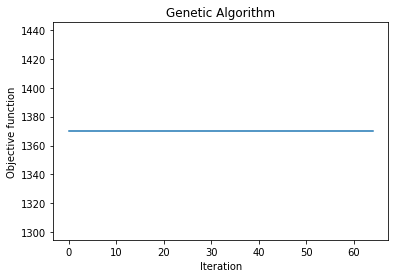



All Paths:
   node_from  node_to  distance  activated
0          1        2       220          1
1          1        3      1500          0
2          2        4       650          1
3          2        5       900          0
4          4        7       500          1
5          5        7       400          0
6          3        6       500          0
7          6        7       400          0

Selected Paths:
   node_from  node_to  distance  activated
0          1        2       220          1
2          2        4       650          1
4          4        7       500          1

Total path: 1370.0


In [84]:
nVars = len(paths)

def f(x):
    pen = 0
    
    # constraint ORIGIN
    node_origin = int(nodes.node[nodes.description == 'origin'])
    summ_origin = sum([x[p] for p in paths.index[paths.node_from == node_origin]])
    if summ_origin != 1:
        pen += 1000000 * np.abs(summ_origin - 1)

    
    # constraint DESTINATION
    node_destination = int(nodes.node[nodes.description == 'destination'])
    summ_destination = sum([x[p] for p in paths.index[paths.node_to == node_destination]])
    if summ_destination != 1:
        pen += 1000000 * np.abs(summ_destination - 1)
    
    # constaint BALANCE
    nodes_middle = nodes.node[nodes.description == 'middle point']
    for node in nodes_middle:
        summ_in = sum([x[p] for p in paths.index[paths.node_to == node]])
        summ_out= sum([x[p] for p in paths.index[paths.node_from == node]])
        if summ_in != summ_out: 
            pen += 1000000 * np.abs(summ_in - summ_out)
    
    obj_fun = sum(x[p]*paths.distance[p] for p in paths.index)
    return obj_fun + pen

varbounds = np.array([[0,1]]*nVars)
vartype = np.array([['int']]*nVars)

model = ga(function=f, dimension=nVars, variable_type_mixed=vartype, variable_boundaries = varbounds)
model.run()


#print
x = model.best_variable
objFun = model.best_function
paths['activated'] = 0
for p in paths.index:
    paths.activated[p] = x[p]

print('\n\nAll Paths:')
print(paths)

print('\nSelected Paths:')
print(paths[paths.activated==1])

print('\nTotal path:', objFun)

## Swarm Particle

In [ ]:
import numpy as np
from pyswarm import pso

def model_obj(x):
    pen = 0
    x[0] = np.round(x[0],0)
    if not -x[0]+2*x[1]*x[0] <= 8 :
        pen = np.inf
    if not 2*x[0] +x[1] <= 14 :
        pen = np.inf
    if not 2*x[0] - x[1] <= 10:
        pen = np.inf
    obj_fun = -(x[0] + x[1]*x[0]) + pen
    return obj_fun

def cons(x):
    return []

lb = [0,0]
ub = [10,10]
x0 = [0,0]

xopt, fopt = pso(model_obj, lb, ub, x0, cons)

print(f'x: {xopt[0]}')
print(f'y: {xopt[1]}')

Stopping search: Swarm best objective change less than 1e-08
x: 5.0
y: 1.2999999918004863


## CP programming

In [9]:
from ortools.sat.python import cp_model
import numpy as np

class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            print('%s=%i' % (v, self.Value(v)), end=' ')
        print()

    def solution_count(self):
        return self.__solution_count

model = cp_model.CpModel()

x = model.NewIntVar(0, 1000, 'x')
y = model.NewIntVar(0, 1000, 'y')
z = model.NewIntVar(0, 1000, 'z')

model.Add(2*x + 7*y + 3*z <= 50)
model.Add(3*x - 5*y + 7*z <= 45)
model.Add(5*x + 2*y - 6*z <= 37)
model.Add(x+y+z >= 10)
#model.Maximize(2*x + 2*y + 3*z)

solver = cp_model.CpSolver()
status = solver.Solve(model)

print('Status = ', solver.StatusName(status))
print('FO = ', solver.ObjectiveValue())
print('x = ', solver.Value(x))
print('y = ', solver.Value(y))
print('z = ', solver.Value(z))

solution_printer = VarArraySolutionPrinter([x, y, z])
status = solver.SearchForAllSolutions(model, solution_printer)

Status =  OPTIMAL
FO =  0.0
x =  4
y =  6
z =  0
x=4 y=6 z=0 
x=4 y=5 z=1 
x=4 y=5 z=2 
x=4 y=4 z=2 
x=4 y=4 z=3 
x=8 y=1 z=1 
x=8 y=0 z=2 
x=8 y=0 z=3 
x=8 y=1 z=2 
x=8 y=2 z=2 
x=8 y=3 z=2 
x=8 y=4 z=2 
x=8 y=1 z=3 
x=8 y=2 z=3 
x=8 y=3 z=3 
x=8 y=2 z=4 
x=8 y=3 z=4 
x=7 y=2 z=1 
x=4 y=4 z=4 
x=7 y=3 z=1 
x=7 y=4 z=1 
x=7 y=1 z=2 
x=4 y=3 z=3 
x=4 y=3 z=4 
x=7 y=0 z=3 
x=7 y=1 z=3 
x=7 y=2 z=3 
x=7 y=3 z=3 
x=7 y=2 z=2 
x=7 y=3 z=2 
x=7 y=4 z=2 
x=7 y=1 z=4 
x=7 y=2 z=4 
x=7 y=3 z=4 
x=7 y=3 z=5 
x=6 y=1 z=4 
x=6 y=2 z=4 
x=6 y=3 z=4 
x=6 y=1 z=3 
x=1 y=2 z=7 
x=0 y=3 z=8 
x=1 y=3 z=8 
x=0 y=3 z=7 
x=4 y=3 z=5 
x=6 y=2 z=3 
x=6 y=3 z=3 
x=6 y=4 z=3 
x=6 y=2 z=2 
x=1 y=3 z=6 
x=1 y=3 z=7 
x=6 y=3 z=1 
x=0 y=4 z=6 
x=1 y=4 z=5 
x=1 y=4 z=6 
x=6 y=3 z=2 
x=6 y=4 z=1 
x=6 y=4 z=2 
x=6 y=5 z=1 
x=6 y=2 z=5 
x=6 y=3 z=5 
x=0 y=4 z=7 
x=0 y=5 z=5 
x=1 y=5 z=4 
x=2 y=2 z=6 
x=2 y=2 z=7 
x=2 y=3 z=5 
x=2 y=4 z=4 
x=2 y=4 z=5 
x=5 y=1 z=4 
x=2 y=5 z=3 
x=2 y=3 z=6 
x=5 y=1 z=5 
x=2 y=4 z=6 
x=

## Second Orer Cone Programming

In [23]:
model = pyo.ConcreteModel()

# vars initialization
model.C = pyo.Var(range(1,4))
model.n = pyo.Var(range(1,4), within = Integers, bounds = (0,1000))

C = model.C
n = model.n

# constraint
model.tot_production = pyo.Constraint(expr= pyo.summation(n) == 2100)
model.C1 = pyo.Constraint( expr = C[1] == 0.01*n[1]**2 + 2*n[1])
model.C2 = pyo.Constraint( expr = C[2] == 6*n[2])
model.C3 = pyo.Constraint( expr = C[3] == 7*n[3])

# objective function
model.obj = pyo.Objective(expr= pyo.summation(C))

opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

# model results
print('--'*33)
print(f'n1: {pyo.value(n[1])}')
print(f'n2: {pyo.value(n[2])}')
print(f'n3: {pyo.value(n[3])}')
print(f'n_tot: {pyo.value(pyo.summation(n))}')

print('--'*33)
print(f'C1: {pyo.value(C[1])}')
print(f'C2: {pyo.value(C[2])}')
print(f'C3: {pyo.value(C[3])}')
print(f'C_tot: {pyo.value(pyo.summation(C))}')

------------------------------------------------------------------
n1: 250.00000000102202
n2: 1000.0000099974941
n3: 849.9999900014838
n_tot: 2100.0
------------------------------------------------------------------
C1: 1125.0000000071543
C2: 6000.000059984964
C3: 5949.999930010386
C_tot: 13074.999990002503


In [39]:
model = pyo.ConcreteModel()

# vars initialization
model.n1 = pyo.Var(within = Integers, bounds = (0,1000))
model.n2 = pyo.Var(within = Integers, bounds = (0,1000))
model.n3 = pyo.Var(within = Integers, bounds = (0,1000))

n1 = model.n1
n2 = model.n2
n3 = model.n3

c1 = 0.01*n1**2 + 2*n1 
c2 = 6*n2*n1
c3 = 7*n3

# constraint
model.tot_production = pyo.Constraint(expr= n1+n2+n3 == 2100)

# objective function
model.obj = pyo.Objective(expr=  c1+c2+c3)

opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

# model results
print('--'*33)
print(f'n1: {round(pyo.value(n1))}')
print(f'n2: {round(pyo.value(n2))}')
print(f'n3: {round(pyo.value(n3))}')
print(f'n_tot: {round(pyo.value(n1 + n2 + n3))}')

print('--'*33)
print(f'c1: {round(pyo.value(c1))}')
print(f'c2: {round(pyo.value(c2))}')
print(f'c3: {round(pyo.value(c3))}')
print(f'c_tot: {round(pyo.value(c1 + c2 + c3))}')

------------------------------------------------------------------
n1: 100
n2: 1000
n3: 1000
n_tot: 2100
------------------------------------------------------------------
c1: 300
c2: 600000
c3: 7000
c_tot: 607300


## Linearization BigM

In [60]:
model = pyo.ConcreteModel()

# vars initialization
model.c = pyo.Var(range(1,4))
model.n = pyo.Var(range(1,4), within = Integers, bounds = (0,1000))
model.b = pyo.Var(within=Integers, bounds=(0,2))

c = model.c
n = model.n
b = model.b
M = 1000000

# constraint
model.tot_production = pyo.Constraint(expr= pyo.summation(n) == 2100)
model.c1 = pyo.Constraint( expr = c[1] == 2*n[1])
#model.c2 = pyo.Constraint( expr = c[2] == b*(6*n[2] + 1000))

model.c2a = pyo.Constraint(expr = -b*M <= c[2])
model.c2b = pyo.Constraint(expr = c[2] <= b*M)
model.c2c = pyo.Constraint(expr = -(1-b)*M <= c[2] - (6*n[2] + 1000))
model.c2d = pyo.Constraint(expr = c[2] - (6*n[2] + 1000) <= (1-b)*M)

model.c2n= pyo.Constraint( expr = n[2] <= b*1000)

model.c3 = pyo.Constraint( expr = c[3] == 7*n[3])


# objective function
model.obj = pyo.Objective(expr= pyo.summation(c))

#opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt = SolverFactory('glpk')
opt.solve(model)

# model results
print('--'*10)
print(f'b: {pyo.value(b)}')

print('--'*10)
print(f'n1: {round(pyo.value(n[1]))}')
print(f'n2: {round(pyo.value(n[2]))}')
print(f'n3: {round(pyo.value(n[3]))}')
print(f'n_tot: {round(pyo.value(pyo.summation(n)))}')

print('--'*10)
print(f'c1: {round(pyo.value(c[1]))}')
print(f'c2: {round(pyo.value(c[2]))}')
print(f'c3: {round(pyo.value(c[3]))}')
print(f'c_tot: {round(pyo.value(pyo.summation(c)))}')

--------------------
b: 1.0
--------------------
n1: 1000
n2: 1000
n3: 100
n_tot: 2100
--------------------
c1: 2000
c2: 7000
c3: 700
c_tot: 9700


## Linearization of binary*binary

In [6]:
model = pyo.ConcreteModel()

# vars initialization
model.c = pyo.Var(range(1,4))
model.n = pyo.Var(range(1,4), within = Integers, bounds = (0,1000))
model.b = pyo.Var(range(1,4), within=Binary)
model.z = pyo.Var(within=Binary)

c = model.c
n = model.n
b = model.b
z = model.z

# constraint
model.tot_production = pyo.Constraint(expr= pyo.summation(n) == 2100)
model.c1 = pyo.Constraint( expr = c[1] == 2*n[1])
model.c1n= pyo.Constraint( expr = n[1] <= b[1]*1000)

model.c2 = pyo.Constraint(expr = c[2] == 6*n[2])
model.c2n= pyo.Constraint(expr = n[2] <= z*1000)
model.c2a= pyo.Constraint(expr = z <= b[1])
model.c2b= pyo.Constraint(expr = z <= b[2])
model.c2c= pyo.Constraint(expr = z >= b[1] +b[2] -1 )

model.c3 = pyo.Constraint( expr = c[3] == 7*n[3])


# objective function
model.obj = pyo.Objective(expr= pyo.summation(c))

#opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt = SolverFactory('glpk')
opt.solve(model)

# model results
print('--'*10)
print(f'b1: {pyo.value(b[1])}')
print(f'b2: {pyo.value(b[2])}')

print('--'*10)
print(f'n1: {round(pyo.value(n[1]))}')
print(f'n2: {round(pyo.value(n[2]))}')
print(f'n3: {round(pyo.value(n[3]))}')
print(f'n_tot: {round(pyo.value(pyo.summation(n)))}')

print('--'*10)
print(f'c1: {round(pyo.value(c[1]))}')
print(f'c2: {round(pyo.value(c[2]))}')
print(f'c3: {round(pyo.value(c[3]))}')
print(f'c_tot: {round(pyo.value(pyo.summation(c)))}')

--------------------
b1: 1.0
b2: 1.0
--------------------
n1: 1000
n2: 1000
n3: 100
n_tot: 2100
--------------------
c1: 2000
c2: 6000
c3: 700
c_tot: 8700


## Advanced features of PyOmo

In [13]:
def run():
    ## create the model
    model = pyo.ConcreteModel()

    ## paramters of the model
    model.T = pyo.Param(initialize = 10)
    T = model.T

    model.M = pyo.Param(initialize = 4)
    M = model.M

    ## sets of the model ==> range of the parameters
    model.setT = pyo.RangeSet(1, T)
    setT = model.setT

    model.setM = pyo.RangeSet(1, M)
    setM = model.setM

    ## variables
    model.x = pyo.Var(setM, setT, within = Integers, bounds=(0,15))
    x = model.x

    ## objective
    model.obj = pyo.Objective(expr = sum([x[m,t] for t in setT for m in setM]),
                              sense = maximize)

    ## constraints
    model.c1 = pyo.Constraint(setT, rule = rule_1)
    model.c2 = pyo.Constraint(range(3, T+1), rule = rule_2)
    model.c3 = pyo.Constraint(setT, rule = rule_3)
    model.c4 = pyo.Constraint(range(2, T+1), rule = rule_4)

    ## solve model
    opt = SolverFactory('glpk')
    opt.solve(model)

    ## extract data from the optimize model
    results_cont = dict()
    for i in range(1, M+1):
        hours_cont = list()
        [hours_cont.append(pyo.value(x[i,j])) for j in range(1, T+1)]
        results_cont[i] = hours_cont
        
    df = pd.DataFrame.from_dict(results_cont, orient='index', columns=range(1, T+1))
    
    df['TOT'] = df.sum(axis=1)
    
    ## display the results of the model
    print(f'Objective Function value: {pyo.value(model.obj)}')
    print()
    print(df)

## rules for constraints:
def rule_1(model, t): return 2*model.x[2,t] - 8*model.x[3,t] <= 0
def rule_2(model, t): return model.x[2,t] - 2*model.x[3,t-2] + model.x[4,t] >= 1
def rule_3(model, t): return sum([model.x[m,t] for m in model.setM]) <= 50                    
def rule_4(model, t): return model.x[1,t] + model.x[2,t-1] + model.x[3,t] + model.x[4,t] <= 10

run()

Objective Function value: 142.0

      1    2    3    4    5    6    7    8    9    10   TOT
1  15.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0   2.0  20.0
2   9.0  0.0  9.0  4.0  8.0  4.0  9.0  4.0  4.0  15.0  66.0
3   7.0  1.0  4.0  1.0  2.0  1.0  4.0  1.0  1.0   4.0  26.0
4  15.0  0.0  6.0  0.0  1.0  1.0  2.0  0.0  5.0   0.0  30.0


## Final Problems

In [20]:
## garden problem

model = pyo.ConcreteModel()

model.x = pyo.Var(bounds = (0, None))
model.y = pyo.Var(bounds = (0, None))
x = model.x 
y = model.y

model.obj = pyo.Objective(expr = x*y, sense = maximize)

model.c1 = pyo.Constraint(expr = 2*x + y <= 100)

opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

print(f'x: {np.round(pyo.value(x), 2)}')
print(f'y: {np.round(pyo.value(y), 2)}')

x: 25.0
y: 50.0


In [67]:
## Rental Car problem

model = pyo.ConcreteModel()

model.n = pyo.Var(bounds = (0, None), within = Integers)
model.p = pyo.Var(bounds = (50, 200))
n = model.n
p = model.p

model.obj = pyo.Objective(expr = n*p, sense = maximize)

model.demand_const = pyo.Constraint(expr = 1001-5*p == n)

opt = SolverFactory('ipopt', executable='/usr/local/Cellar/ipopt/3.14.7/bin/ipopt')
opt.solve(model)

print(f'n: {np.round(pyo.value(n), 2)}')
print(f'p: {np.round(pyo.value(p), 2)}')

n: 500.5
p: 100.1


In [80]:
## routing problem

nodes = pd.read_excel('data/inputs_route.xlsx', sheet_name = 'nodes')
paths = pd.read_excel('data/inputs_route.xlsx', sheet_name = 'paths')

model = pyo.ConcreteModel()

n_vars = len(paths)

## variables
model.x = pyo.Var(range(n_vars), within = Binary)
x = model.x

## constraints
init_node = int(nodes.node[nodes.description == 'origin'])
model.c1 = pyo.Constraint(expr = sum(x[p] for p in paths.index[paths.node_from == init_node]) == 1)

final_node = int(nodes.node[nodes.description == 'destination'])
model.c2 = pyo.Constraint(expr = sum(x[p] for p in paths.index[paths.node_to == final_node]) == 1)

middle_nodes = (nodes.node[nodes.description == 'middle point'])
model.c3 = pyo.ConstraintList()
for node in middle_nodes:
    sum_in = sum(x[p] for p in paths.index[paths.node_to == node])
    sum_out= sum(x[p] for p in paths.index[paths.node_from == node])
    model.c3.add(expr = sum_in == sum_out)

## objective function
model.obj = pyo.Objective(expr = sum(x[p]*paths.distance[p] for p in paths.index))

## solve the model
opt = SolverFactory('glpk')
opt.solve(model)

print(f'Optimum path lenght: {round(pyo.value(model.obj))}')

paths['selected'] = [round(pyo.value(x[p])) for p in range(n_vars)]

print()
print(paths[paths.selected == 1])

Optimum path lenght: 1370

   node_from  node_to  distance  selected
0          1        2       220         1
2          2        4       650         1
4          4        7       500         1


In [83]:
import pyomo.environ as pyo, numpy as np, pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory

#input
buses = pd.read_excel('data/powerSystem.xlsx', sheet_name='bus')
generations = pd.read_excel('data/powerSystem.xlsx', sheet_name='generation')
loads = pd.read_excel('data/powerSystem.xlsx', sheet_name='load')
lines = pd.read_excel('data/powerSystem.xlsx', sheet_name='line')
Nb = len(buses)
Ng = len(generations)
Nd = len(loads)
Nl = len(lines)

#modelo
model = pyo.ConcreteModel()
model.Pg = pyo.Var(range(Ng))
model.Pl = pyo.Var(range(Nl))
model.theta = pyo.Var(range(Nb), bounds=(-np.pi,np.pi))
Pg = model.Pg
Pl = model.Pl
theta = model.theta

#objective function
model.obj = pyo.Objective(expr= sum([Pg[g]*generations.cost[g] for g in generations.index]), sense=minimize)

#power balance
model.balance = pyo.ConstraintList()
for n in buses.index:
    sum_Pg = sum([Pg[g] for g in generations.index[generations.bus==n]])
    sum_Pls = sum([Pl[l] for l in lines.index[lines.from_bus==n]])
    sum_Plr = sum([Pl[l] for l in lines.index[lines.to_bus==n]])
    sum_Pd = sum([loads.load[d] for d in loads.index[loads.bus==n]])
    model.balance.add(expr= sum_Pg - sum_Pls + sum_Plr == sum_Pd)

#power flow
model.flux = pyo.ConstraintList()
for l in lines.index:
    Bl = lines.Bl[l]
    n_send = lines.from_bus[l]
    n_rec = lines.to_bus[l]
    delta_theta = theta[n_send]-theta[n_rec]
    model.flux.add(expr= Pl[l] == Bl*delta_theta)

#generator limits
model.limger = pyo.ConstraintList()
for g in generations.index:
    model.limger.add(inequality(0,Pg[g],generations.pgmax[g]))

#power flow limits
model.limflux = pyo.ConstraintList()
for l in lines.index:
    model.limflux.add(inequality(-lines.plmax[l],Pl[l],lines.plmax[l]))

#reference
model.ref = pyo.Constraint(expr= theta[0] == 0)

#solve
opt = SolverFactory('glpk')
opt.solve(model)

#result


7 Set Declarations
    Pg_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    Pl_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    balance_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    flux_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    limflux_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    limger_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}
    theta_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen 